In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F    
from torch.optim import AdamW
from torch.amp import GradScaler
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.tensorboard import SummaryWriter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
# from tqdm.notebook import tqdm
import time

import json
import os

CHECKPOINT_DIR = os.path.join("checkpoints", "GPT")
LOG_DIR = os.path.join("logs", "GPT")
RESULTS_DIR = os.path.join("results", "GPT")

os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)


In [2]:
from GPT_mj import GPT, ConfigGPT
from train_lm import train, evaluate, evaluate_ppl, ConfigTrain
from utils import init_dataloader, WarmupThenCosine, set_seed, count_params, save_checkpoint, load_checkpoint
from bpe_hf import train_bytelevel_bpe, load_tokenizer, SPECIAL_TOKENS

In [3]:
data_dir = "../data/"
# without nl
# train_file = "Shakespeare_clean_train.txt"
# val_file = "Shakespeare_clean_valid.txt"
# test_file = "Shakespeare_clean_test.txt"
# with nl
train_file = "Shakespeare_clean_w_nl_train.txt"
val_file = "Shakespeare_clean_w_nl_valid.txt"
test_file = "Shakespeare_clean_w_nl_test.txt"

train_file = os.path.join(data_dir, train_file)
test_file = os.path.join(data_dir, test_file)
val_file = os.path.join(data_dir, val_file)

with open(train_file, "r", encoding="utf-8") as f:
    train_text = f.read().strip()

with open(val_file, "r", encoding="utf-8") as f:
    val_text = f.read().strip()

with open(test_file, "r", encoding="utf-8") as f:
    test_text = f.read().strip()

In [4]:
N_MERGES = 200
MIN_FREQ = 2

SPECIAL_TOKENS = SPECIAL_TOKENS.copy()
PAD_TOKEN = SPECIAL_TOKENS.get("pad", "<pad>")
BOS_TOKEN = SPECIAL_TOKENS.get("bos", "<bos>")
EOS_TOKEN = SPECIAL_TOKENS.get("eos", "<eos>")


bpe_tokenizer = train_bytelevel_bpe(files=[train_file],
                                merges=N_MERGES, 
                                min_frequency=MIN_FREQ,
                                special_tokens=SPECIAL_TOKENS,
                                lowercase=False,
                                add_prefix_space=True,
                                save_filename=f"bpe_shakespeare_{N_MERGES}")

encode = bpe_tokenizer.encode
decode = bpe_tokenizer.decode
vocab_size = bpe_tokenizer.get_vocab_size()
print("vocab size: ", vocab_size)
print("BPE tokenizer vocab: ", list(bpe_tokenizer.get_vocab().items())[:100])

PAD_TOKEN_ID = bpe_tokenizer.token_to_id(PAD_TOKEN) 
BOS_TOKEN_ID = bpe_tokenizer.token_to_id(BOS_TOKEN)
EOS_TOKEN_ID = bpe_tokenizer.token_to_id(EOS_TOKEN)

train_ids = encode(train_text).ids
test_ids = encode(test_text).ids
val_ids = encode(val_text).ids

print("train text charachters length: ", len(train_text))
print("train text words count: ", len(train_text.split()))
print("train ids length: ", len(train_ids))
print("train text first 100 chars: ", train_text[:25])
print("train ids first 100 ids: ", train_ids[:25])
print("train ids first 100 individual tokens: ", [bpe_tokenizer.id_to_token(i) for i in train_ids[:25]]) 

vocab size:  460
BPE tokenizer vocab:  [('§', 104), ('ě', 219), ('ł', 258), ('ed', 332), ('art', 431), ('ĠG', 387), ('}', 96), ('ó', 179), ('è', 168), ('Ġand', 299), ('Ċ', 202), ('$', 7), ('Ġwith', 352), ('S', 54), ('ĠI', 277), ('Ġsu', 424), ("Ġ'", 418), ('h', 75), ('H', 43), ('{', 94), ('a', 68), ('²', 114), ('ĠR', 391), ('á', 161), ('ĝ', 221), ('ha', 271), ('Ġth', 295), ('ÿ', 191), ('Ġh', 294), ('al', 366), ('K', 46), ('ĳ', 243), ('ct', 444), ('Ġw', 268), ('Ď', 206), ('R', 53), ('ć', 199), ('re', 270), ('ake', 432), ('ter', 447), ('il', 439), ('ü', 188), ('Ē', 210), ('q', 84), ('ĠH', 325), ('ħ', 231), ('ċ', 203), ('¼', 124), ('hat', 296), ('ĠE', 345), ('if', 427), ('ET', 398), ('<eos>', 3), ('±', 113), ('Ġthou', 369), ('Ä', 132), ('Ï', 143), ('est', 412), ('Ġyou', 297), ('Ġme', 330), ('ar', 290), ('ĠA', 293), ('?', 34), ('7', 26), ('Ġwill', 400), ('Æ', 134), ('ê', 170), ('Ü', 156), ('<', 31), ('ı', 241), ('ĠĊ', 360), ('č', 205), ('ò', 178), (')', 12), ('d', 71), ('ght', 354), ('İ', 2

In [ ]:
SEED = 123
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# hyperparameters 
# tokenizer
# N_MERGES = 200
# MIN_FREQ = 2
# data
BATCH_SIZE = 64
BLOCK_SIZE = 128
SHUFFLE_TRAIN = True

#  model
N_EMBED = 128
N_HEADS = 4
N_LAYERS = 2
DROPOUT = 0.1
# optimizer
LR = 3e-4
WEIGHT_DECAY = 1e-3
# scheduler
ETA_MIN = 1e-7

# training loop
EPOCHS = 60
ES_PATIENCE = 5
ES_TOLERANCE = 1e-6
GRAD_ACCUM_STEPS = 1
USE_AMP = False # IMPORTANT: set to False if training on CPU training 

# checkpoints
EVAL_INTERVAL = EPOCHS  # evaluate every n epochs
CKPT_INTERVAL = EPOCHS  # save checkpoint every n epochs

# make unique checkpoint file prefix from the parameters
ckpt_file_prefix = f"gpt_em{N_EMBED}_hd{N_HEADS}_ly{N_LAYERS}_bpe{N_MERGES}"
all_hparams_cfg_filename = f"{ckpt_file_prefix}_hparams.json"

# config for training
cfg_train = ConfigTrain(device=DEVICE,
                    epochs=EPOCHS, 
                    early_stop_patience=ES_PATIENCE,
                    early_stop_tolerance=ES_TOLERANCE,
                    grad_accum_steps=GRAD_ACCUM_STEPS,
                    # max_grad_norm=data.get("max_grad_norm", 1.0),
                    use_amp=USE_AMP,
                    seed=SEED,
                    eval_interval=EVAL_INTERVAL,
                    ckpt_interval=CKPT_INTERVAL,
                    ckpt_dir=CHECKPOINT_DIR,
                    ckpt_best_filename=f"{ckpt_file_prefix}_best.pt",
                    ckpt_last_filename=f"{ckpt_file_prefix}_last.pt",
                    log_dir=os.path.join(LOG_DIR, f"{ckpt_file_prefix}", f'lr{LR}_drop{DROPOUT}_{time.strftime("%Y%m%d__%H%M%S")}'),
                    )
# config for model
cfg_model = ConfigGPT(
                    vocab_size=vocab_size,
                    block_size=BLOCK_SIZE,  
                    n_embed=N_EMBED,
                    n_head=N_HEADS,  
                    n_layer=N_LAYERS, 
                    dropout=DROPOUT,
                    bias=False,
                    )

# print all log and checkpoint dir and filenames
print("number of batches in train loader: ", len(train_ids)//BATCH_SIZE)
print("number of batches in test loader: ", len(test_ids)//BATCH_SIZE)
print("number of batches in val loader: ", len(val_ids)//BATCH_SIZE)

print("log dir: ", cfg_train.log_dir)
print("checkpoint dir: ", cfg_train.ckpt_dir)
print("checkpoint best filename: ", cfg_train.ckpt_best_filename)
print("checkpoint last filename: ", cfg_train.ckpt_last_filename)

# model parameters
print("vocab size: ", vocab_size)
print("number of model parameters: ", count_params(GPT(config=cfg_model)))

number of batches in train loader:  7785
number of batches in test loader:  930
number of batches in val loader:  924
log dir:  logs/GPT/em128_hd4_ly2_bpe200/lr0.0003_drop0.1_20250823__141238
checkpoint dir:  checkpoints/GPT
checkpoint best filename:  em128_hd4_ly2_bpe200_best.pt
checkpoint last filename:  em128_hd4_ly2_bpe200_last.pt
vocab size:  460
number of model parameters:  528460


In [ ]:
set_seed(cfg_train.seed)
train_loader = init_dataloader(train_ids, BLOCK_SIZE, BATCH_SIZE, train=True, shuffle=SHUFFLE_TRAIN)
test_loader = init_dataloader(test_ids, BLOCK_SIZE, BATCH_SIZE, train=False, shuffle=False)
val_loader = init_dataloader(val_ids, BLOCK_SIZE, BATCH_SIZE, train=False, shuffle=False)

model = GPT(config=cfg_model,)
model.to(cfg_train.device)
model.compile(mode="reduce-overhead", backend="inductor")

optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY, foreach=True if DEVICE=="cpu" else None)


lr_scheduler = WarmupThenCosine(optimizer, warmup_steps=500, T_max=cfg_train.epochs * len(train_loader) // max(1, cfg_train.grad_accum_steps), eta_min=ETA_MIN)
# rl_scheduler = CosineAnnealingLR(optimizer, T_max=cfg.epochs * len(train_loader) // max(1, cfg.grad_accum_steps), eta_min=ETA_MIN)
# rl_scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=2 * len(train_loader) // max(1, cfg.grad_accum_steps), T_mult=2, eta_min=ETA_MIN)

scaler = GradScaler(enabled=cfg_train.use_amp)

summary_writer = SummaryWriter(log_dir=cfg_train.log_dir, flush_secs=5)

# inspect the model
print(f"Model parameters: {count_params(model):_}")
print("vocab size: ", vocab_size)
print(f"excepted iniital CE loss( uniform model ): {-np.log(1/vocab_size):.4f}, ppl: {np.exp(-np.log(1/vocab_size)):.4f}")
# evaluate the untrained model
val_loss = evaluate(model, val_loader, device=cfg_train.device)
val_ppl = np.exp(val_loss)
print(f"not trained model Initial validation loss: {val_loss:.4f}, ppl: {val_ppl:.4f}")
print(model)

Model parameters: 528_460
vocab size:  460
excepted iniital CE loss( uniform model ): 6.1312, ppl: 460.0000
not trained model Initial validation loss: 6.1536, ppl: 470.4104
GPT(
  (embedding): Embedding(460, 128)
  (position_embedding): Embedding(128, 128)
  (dropout_em): Dropout(p=0.1, inplace=False)
  (decoder_blocks): Sequential(
    (0): DecoderBlock(
      (layer_norm_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (attention): CausalSelfAttention(
        (self_attn): Linear(in_features=128, out_features=384, bias=False)
        (dropout_attn): Dropout(p=0.1, inplace=False)
        (lin_proj): Linear(in_features=128, out_features=128, bias=False)
        (dropout_proj): Dropout(p=0.1, inplace=False)
      )
      (layer_norm_mlp): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (mlp): SimpleMLP(
        (lin_wide): Linear(in_features=128, out_features=512, bias=False)
        (gelu): GELU(approximate='none')
        (lin_proj_back): Linear(in_features=

In [ ]:
train_results = train(model, train_loader, val_loader, cfg=cfg_train,
                      optimizer=optimizer, scheduler=lr_scheduler, scaler=scaler,
                      writer=summary_writer)

Training Progress: 100%|██████████| 60/60 [15:01<00:00, 15.03s/it, no_improve=0/5, train_loss=2.7119, train_ppl=15.06, val_loss=2.6226, val_ppl=13.77]


In [ ]:
# save all the hyperparameters into a json file
rl_scheduler_state_dict = lr_scheduler.state_dict() if lr_scheduler.__class__.__name__ != "WarmupThenCosine" else {
            k:v for k, v in lr_scheduler.state_dict().items() if k != "cosine"}
all_hparams_cfg = {
    "tokenizer" : {
        "type": "bytelevel_bpe",
        "n_merges": N_MERGES,
        "min_frequency": MIN_FREQ,
        "special_tokens": SPECIAL_TOKENS,
    },
    "data": {
        "batch_size": BATCH_SIZE,
        "block_size": BLOCK_SIZE,
        "shuffle_train": SHUFFLE_TRAIN,
    },
    "model": vars(cfg_model).copy(),
    "optimizer": {
        "type": optimizer.__class__.__name__,
        "lr": LR,
        "weight_decay": WEIGHT_DECAY,
        "defaults": optimizer.defaults,
    },
    "lr_scheduler": {
        "type": lr_scheduler.__class__.__name__,
        "eta_min": ETA_MIN,
        "state_dict": rl_scheduler_state_dict,
    },
    "scaler": {
        "type": scaler.__class__.__name__,
        "enabled": scaler.is_enabled(),
        "state_dict": scaler.state_dict(),
    },
    "training": vars(cfg_train).copy(),
    "results": train_results,
}

# save it to checkpoint dir, same prefix as checkpoint files
with open(os.path.join(CHECKPOINT_DIR, all_hparams_cfg_filename), "w") as f:
    json.dump(all_hparams_cfg, f, indent=4)

# write it to tensorboard
summary_writer.add_text("config/json", "```json\n" + json.dumps(all_hparams_cfg, indent=2, sort_keys=True) + "\n```", global_step=0)
summary_writer.flush()
summary_writer.close()

,train_loss,train_ppl,val_ppl,val_loss,epochs
0,2.711903,15.057908,13.771815,2.622624,1


,train_loss,train_ppl,val_ppl,val_loss,epochs
0,2.711903,15.057908,13.771815,2.622624,1


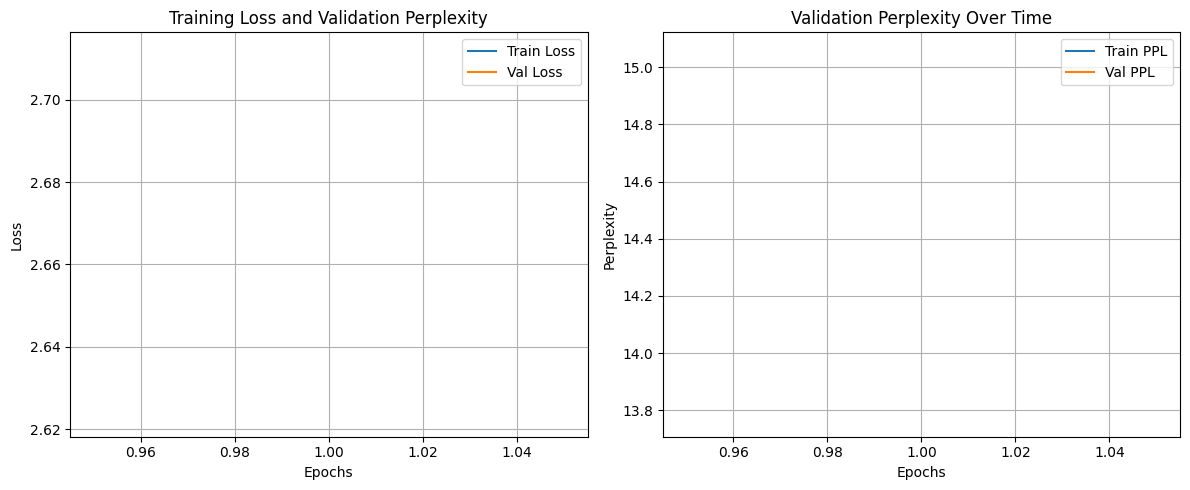

In [ ]:
# make train_loss, train_ppl, val_ppl, val_loss and epochs into a DataFrame
history = train_results["history"]
history_df = pd.DataFrame({
    "train_loss": history["train_loss"],
    "train_ppl": history["train_ppl"],
    "val_ppl": history["val_ppl"],
    "val_loss": history["val_loss"],
    "epochs": range(1, len(history["train_loss"]) + 1)
})

display(history_df.head())
display(history_df.tail())

plt.figure(figsize=(12, 5))
# loss 
plt.subplot(1, 2, 1)
plt.plot(history_df['epochs'], history_df["train_loss"], label="Train Loss")
plt.plot(history_df['epochs'], history_df["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
# plt.xticks(history_df['epochs'][::int(len(history_df['epochs'])//9)+1])  
plt.title("Training Loss and Validation Perplexity")
plt.legend()
plt.grid()

# perplexity
plt.subplot(1, 2, 2)
plt.plot(history_df['epochs'], history_df["train_ppl"], label="Train PPL")
plt.plot(history_df['epochs'], history_df["val_ppl"], label="Val PPL")
plt.xlabel("Epochs")
plt.ylabel("Perplexity")
# plt.xticks(history_df['epochs'][::int(len(history_df['epochs'])//9)+1])  
plt.title("Validation Perplexity Over Time")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
# compare with exponentiated average negative log likelihood
test_nll = evaluate(model, test_loader, cfg_train.device)
test_ppl = np.exp(test_nll)

val_ppl = train_results["best_val_ppl"]
train_ppl = train_results["best_train_ppl"]

val_nll = torch.log(torch.tensor(val_ppl)).item()
train_nll = torch.log(torch.tensor(train_ppl)).item()

# display in a DataFrame
test_results_df = pd.DataFrame({
    "split": ["train", "val", "test"],
    "loss(NLL)": [train_nll, val_nll, test_nll],
    "perplexity": [train_ppl, val_ppl, test_ppl],
})
display(test_results_df)

,split,loss(NLL),perplexity
0,train,2.711035,15.044832
1,val,2.622624,13.771815
2,test,2.721718,15.206430


In [ ]:
# get a batch from validation set and generate text
context_len = 10
batch_gen = 5

context_ids_batch, _ = next(iter(val_loader))
context_ids_batch = context_ids_batch.to(cfg_train.device, non_blocking=True)
# generate text from the model
generated_text = model.generate(context_ids_batch[:batch_gen, :context_len], max_new_tokens=50, temperature=0.9, top_k=20)
print(f">>>> <context>\n", "-" *20, "\n<generated_text>")
for i, text in enumerate(generated_text):
    print("\n", "-" * 80)
    print(">>>>", decode(text[:context_len].tolist()))
    print("-" * 20)
    print(decode(text[context_len:].tolist()))
    if i + 1 >= batch_gen:
        break

>>>> <context>
 -------------------- 
<generated_text>

 --------------------------------------------------------------------------------
>>>>  mine arm'd neck
--------------------
s.




MACBETH
So might, the say, if I dislile;
You was art thou art man intend

 --------------------------------------------------------------------------------
>>>> ?



MARK AN
--------------------
TONY
Dost fellow
He make thine us follow: when if the
wake jerelted to commands; and p

 --------------------------------------------------------------------------------
>>>>  unto his lips thy fa
--------------------
ir:--
It is the prince of the cannot soul
To less the action; that comforth to chen true of my char

 --------------------------------------------------------------------------------
>>>> K ANTONY
He ha
--------------------
s, I come!


SANTONIO
And heaven; I am corry!



BRABANCOTIO
Come, wor

 --------------------------------------------------------------------------------
>>>>  this host, we a